# Import libraries

In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SequentialSampler
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import os
import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.cm as cm
from scipy.stats import norm
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')
results_path = "/content/drive/MyDrive/DeepLearning_2024/DL2024_project/results/"
models_path = "/content/drive/MyDrive/DeepLearning_2024/DL2024_project/models/"


# Format the date as a string
current_date_str = current_datetime.strftime("%Y-%m-%d %H:%M:%S")


Mounted at /content/drive


In [ ]:
# Get the current date and time
current_datetime = datetime.datetime.now()

# Data Loading & Processing

In [5]:
# Load dataset
data = pd.read_csv("/content/drive/MyDrive/DeepLearning_2024/DL2024_project/barcelona last10years.csv", on_bad_lines='skip')
data = data[['datetime', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip', 'precipprob' ,'preciptype', 'windspeed', 'winddir', 'cloudcover']]
data = data.rename(columns={'temp': 'temperature', 'datetime': 'date'})
data['date'] = pd.to_datetime(data['date'], utc=True)
data.set_index('date')
data['preciptype'] =  data['preciptype'].fillna('None')
data['cloudcover'] =  data['cloudcover'].fillna(0)
#data = data.resample('D').mean()
#data = data[['Temperature (C)']]

In [6]:
'''
# Function to encode datetime to sine wave
def datetime_to_sine_wave(date):
    # Get the day of the year (1-366)
    day_of_year = date.dayofyear
    # Get the total number of days in the year (365 or 366 for leap years)
    days_in_year = 366 if date.is_leap_year else 365
    # Normalize day of the year to a value between 0 and 1
    normalized_day = day_of_year / days_in_year
    # Convert to sine wave (range -1 to 1)
    sine_wave = -np.cos(2 * np.pi * normalized_day)
    return sine_wave

# Apply the function to the 'date' column
data['sine_wave'] = data['date'].apply(datetime_to_sine_wave)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['sine_wave'])
plt.title('Sine Wave Encoding of Dates')
plt.xlabel('Date')
plt.ylabel('Sine Wave Value')
plt.grid(True)
plt.show()
'''

"\n# Function to encode datetime to sine wave\ndef datetime_to_sine_wave(date):\n    # Get the day of the year (1-366)\n    day_of_year = date.dayofyear\n    # Get the total number of days in the year (365 or 366 for leap years)\n    days_in_year = 366 if date.is_leap_year else 365\n    # Normalize day of the year to a value between 0 and 1\n    normalized_day = day_of_year / days_in_year\n    # Convert to sine wave (range -1 to 1)\n    sine_wave = -np.cos(2 * np.pi * normalized_day)\n    return sine_wave\n\n# Apply the function to the 'date' column\ndata['sine_wave'] = data['date'].apply(datetime_to_sine_wave)\n\n# Plotting\nplt.figure(figsize=(10, 5))\nplt.plot(data['date'], data['sine_wave'])\nplt.title('Sine Wave Encoding of Dates')\nplt.xlabel('Date')\nplt.ylabel('Sine Wave Value')\nplt.grid(True)\nplt.show()\n"

In [7]:
# Preprocess dataset

# Ensure only numeric columns are used for scaling
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
data_numeric = data[numeric_features]

# Preprocess dataset: standardize all features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

temperature_idx = data_numeric.columns.get_loc('temperature')

# Prepare sequences for transformer
def create_sequences(data, seq_length, target_idx):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, target_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 20
X, y = create_sequences(data_scaled, SEQ_LENGTH, temperature_idx)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)


In [8]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, sampler=SequentialSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, sampler=SequentialSampler(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, sampler=SequentialSampler(test_dataset))


# Transformer Model

In [9]:
# Define the Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, SEQ_LENGTH, model_dim))
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim, 1)

    def forward(self, src):
        src = self.embedding(src) + self.positional_encoding
        src = src.transpose(0, 1)
        output = self.transformer_encoder(src)
        output = output.transpose(0, 1)
        output = self.decoder(output[:, -1, :])
        return output

# Training & Validation Function

In [10]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[2]
model = TransformerModel(input_dim=input_dim, model_dim=32, num_heads=2, num_layers=1)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Early stopping parameters
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0
epoch_losses = []
val_losses = []

def train_and_validate(model: nn.Module,
                       train_loader: DataLoader,
                       val_loader: DataLoader,
                       criterion: nn.Module,
                       optimizer: optim.Optimizer,
                       device: torch.device,
                       models_path: str,
                       results_path: str,
                       scheduler: optim.lr_scheduler._LRScheduler = None,
                       num_epochs: int = 100,
                       log_interval: int = 100,
                       model_name = f"transformer_{current_date_str}") -> None:
    """
    Train and validate the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer for the model parameters.
        scheduler (optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        num_epochs (int): Number of epochs to train the model.
        log_interval (int): Interval for logging training and validation losses.
        device (torch.device): Device to use for training (CPU or GPU).
    """
    global best_val_loss, patience_counter, val_losses, epoch_losses
    iteration = 0


    for epoch in range(num_epochs):
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            iteration += 1
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        epoch_losses.append(epoch_loss)


        # Validation loss calculation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f"{models_path}{model_name}.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping on epoch {epoch+1}, iteration {iteration}')
                break  # Exit the function to stop training

        model.train()
        #if batch_idx == 0:
        #    break
        if scheduler != None:
            scheduler.step()


    # Create a DataFrame and save as CSV
    losses_df = pd.DataFrame({
        'epoch': range(1, len(epoch_losses) + 1),
        'epoch_loss': epoch_losses,
        'val_loss': val_losses
    }).set_index('epoch')

    losses_df.to_csv(f'{results_path}{model_name}_training_validation_losses.csv')
    return losses_df

# Evaluation Function

In [45]:
def evaluate_model(model: nn.Module,
                   test_loader: DataLoader,
                   scaler: StandardScaler,
                   data_numeric: pd.DataFrame,
                   device: torch.device,
                   results_path: str,
                   model_name: str = f"transformer_{current_date_str}") -> None:
    """
    Evaluate the model on the test set and plot the results.

    Args:
        model (nn.Module): The trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test data.
        scaler (StandardScaler): Scaler used to normalize the data.
        data_numeric (pd.DataFrame): Original numeric data for inverse transformation.
        device (torch.device): Device to use for evaluation (CPU or GPU).
    """
    model.eval()
    with torch.no_grad():
        test_preds = []
        test_true = []
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            output = model(X_batch)
            test_preds.append(output.cpu().numpy())  # Move data back to CPU before appending
            test_true.append(y_batch.cpu().numpy())  # Move data back to CPU before appending

        test_preds = np.concatenate(test_preds)
        test_true = np.concatenate(test_true)

        # Inverse transform the predicted and true values
        test_preds_original = scaler.inverse_transform(np.concatenate([test_preds.reshape(-1, 1), np.zeros((test_preds.shape[0], data_numeric.shape[1] - 1))], axis=1))[:, 0]
        test_true_original = scaler.inverse_transform(np.concatenate([test_true.reshape(-1, 1), np.zeros((test_true.shape[0], data_numeric.shape[1] - 1))], axis=1))[:, 0]

        Transformer_error = pd.DataFrame(test_true_original, columns = ['targets'])
        Transformer_error['predictions'] =test_preds_original
        Transformer_error['error'] = Transformer_error['targets'] - Transformer_error['predictions']
        Transformer_error['error_square'] = Transformer_error['error'] ** 2
        Transformer_error.to_csv(f'{results_path}{model_name}.csv', index=False)

        mse = np.mean((test_preds_original - test_true_original) ** 2)
        print(f'Test MSE: {mse:.4f}')


        return mse, Transformer_error

# Running the Model

Epoch 1/100, Training Loss: 0.1521, Validation Loss: 0.2108
Epoch 2/100, Training Loss: 0.1582, Validation Loss: 0.2121
Epoch 3/100, Training Loss: 0.1565, Validation Loss: 0.2118
Epoch 4/100, Training Loss: 0.1563, Validation Loss: 0.2112
Epoch 5/100, Training Loss: 0.1571, Validation Loss: 0.2116
Epoch 6/100, Training Loss: 0.1562, Validation Loss: 0.2123
Epoch 7/100, Training Loss: 0.1546, Validation Loss: 0.2113
Epoch 8/100, Training Loss: 0.1555, Validation Loss: 0.2114
Epoch 9/100, Training Loss: 0.1543, Validation Loss: 0.2113
Epoch 10/100, Training Loss: 0.1542, Validation Loss: 0.2119
Epoch 11/100, Training Loss: 0.1522, Validation Loss: 0.2113
Early stopping on epoch 11, iteration 1045
Test MSE: 3.0814


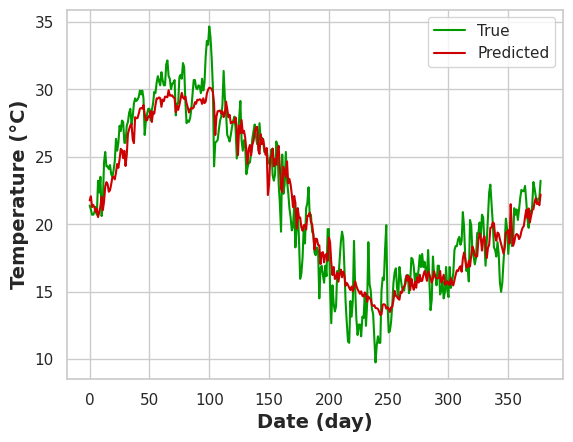

In [46]:
# Train and validate the model
model_name = f"transformer_{current_date_str}_a"
num_epochs=100
log_interval=100
losses_df = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, models_path, results_path, num_epochs=num_epochs, log_interval=log_interval, model_name=model_name)

# Load the best model
model.load_state_dict(torch.load(f"{models_path}{model_name}.pth"))


# Evaluate the model
mse, Transformer_error = evaluate_model(model, test_loader, scaler, data_numeric, device, results_path, model_name)

# Additional Evaluation & Visualizations

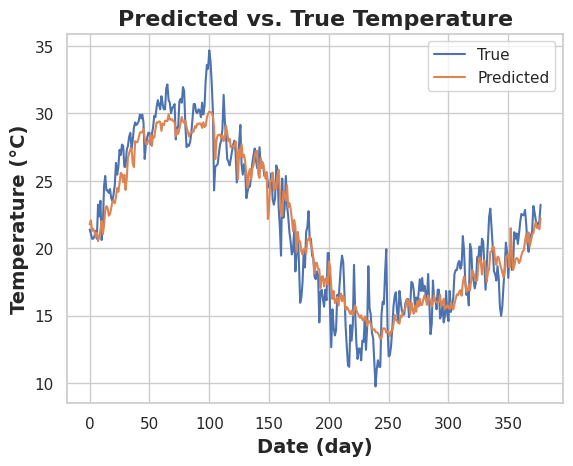

In [64]:
# Plot the results

# Define slightly muted colors
#true_color = (0, 0.8, 0)  # Green
#predicted_color = (0.8, 0.1, 0.1)  # Red
plt.plot(Transformer_error['targets'], label='True') #, color=true_color)
plt.plot(Transformer_error['predictions'], label='Predicted')#, color=predicted_color)
plt.legend()
# Add labels
plt.xlabel('Date (day)', fontsize=14, fontweight='bold')
plt.ylabel('Temperature (°C)', fontsize=14, fontweight='bold')
plt.title('Predicted vs. True Temperature', fontsize=16, fontweight='bold')
plt.savefig(f"{results_path}{model_name}_predicted_vs_true.png", dpi=300)
plt.show()

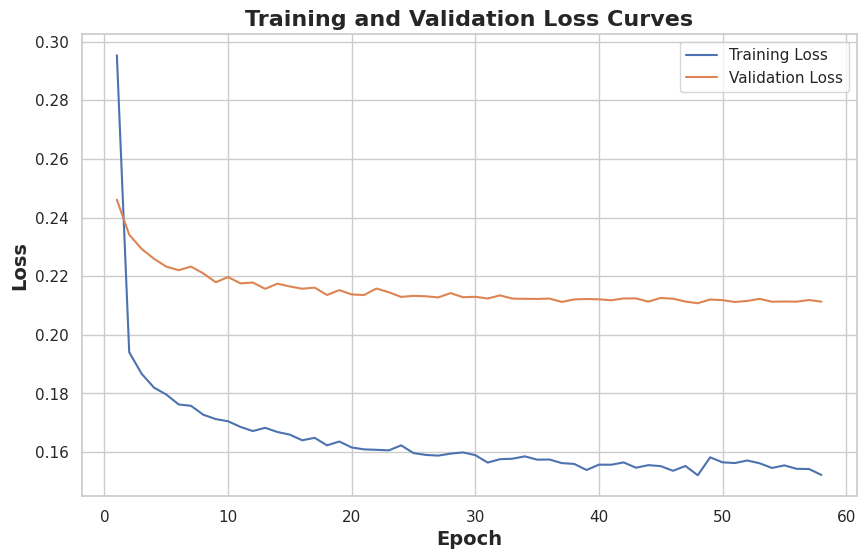

In [63]:
# Load the DataFrame from the CSV file
losses_df = pd.read_csv(f'{results_path}{model_name}_training_validation_losses.csv')

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(losses_df['epoch'], losses_df['epoch_loss'], label='Training Loss')
plt.plot(losses_df['epoch'], losses_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss Curves', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.savefig(f"{results_path}{model_name}_loss_curves.png")
plt.show()

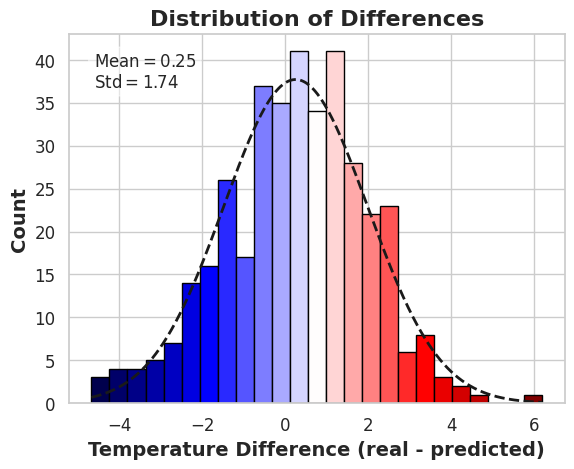

In [48]:
# Assuming Transformer_error['error'] is already defined and imported
bins = 25

# Calculate the histogram data
counts, bin_edges = np.histogram(Transformer_error['error'], bins=bins)

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create a colormap
norm_colormap = Normalize(vmin=min(bin_centers), vmax=max(bin_centers))
cmap = cm.get_cmap('seismic')

# Create the plot
fig, ax = plt.subplots()

# Plot each bar with a color corresponding to its bin center
for count, center in zip(counts, bin_centers):
    color = cmap(norm_colormap(center))
    ax.bar(center, count, width=(bin_edges[1] - bin_edges[0]), color=color, edgecolor='black')

# Fit a Gaussian distribution to the data
mu, std = norm.fit(Transformer_error['error'])

# Plot the Gaussian fit
x = np.linspace(min(bin_edges), max(bin_edges), 1000)
p = norm.pdf(x, mu, std)
ax.plot(x, p * len(Transformer_error['error']) * (bin_edges[1] - bin_edges[0]), 'k--', linewidth=2)

# Add mean and std to the plot
textstr = '\n'.join((
    r'$\mathrm{Mean}=%.2f$' % (mu,),
    r'$\mathrm{Std}=%.2f$' % (std,)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Customize the plot
ax.set_xlabel('Temperature Difference (real - predicted)', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Differences', fontsize=16, fontweight='bold')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Save and show the plot
plt.savefig(f"{results_path}{model_name}_loss_epoch.png", dpi=300)
plt.show()
